### 1. Loss and Accuary Visualization

In [11]:
import os
import pandas as pd

filepath = r'G:\lizulin\network-slimming\logs\sparsity_vgg19_cifar10_s_1e_4'
filepath2 = r'G:\lizulin\network-slimming\logs\fine_tuning_vgg19_cifar100_percent_0.5'
filepath3 = r'G:\lizulin\network-slimming\logs\fine_tuning_vgg19_cifar100_percent_0.5_init'

data = pd.read_csv(os.path.join(filepath3, 'record.csv'))

data

,epoch,loss,prec
0,0,3.9633,0.0732
1,1,3.6238,0.1221
2,2,3.4269,0.1520
3,3,3.3438,0.1846
4,4,2.8814,0.2605
...,...,...,...
155,155,1.6138,0.7150
156,156,1.6170,0.7108
157,157,1.6262,0.7116
158,158,1.6372,0.7138


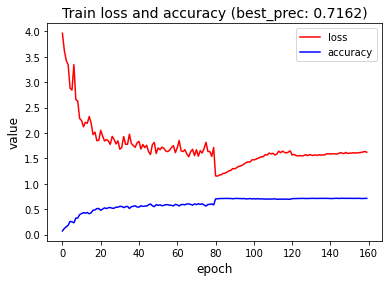

In [12]:
import matplotlib.pyplot as plt

line_loss, = plt.plot(data['loss'], 'r-')
line_prec, = plt.plot(data['prec'], 'b-')
plt.legend([line_loss, line_prec], ['loss', 'accuracy'], loc='upper right')
plt.ylabel('value', fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.title('Train loss and accuracy (best_prec: {:.4f})'.format(max(data['prec'])), fontsize=14)
plt.savefig(os.path.join(filepath3, "record train loss.png"))
plt.show()

### 2. VGG Weight Visualization 

#### 2.1 pruned model file 

In [20]:
import torch

filepath = r'G:\lizulin\network-slimming\logs\prune_vgg19_cifar100_percent_0.5\pruned.pth.tar'

pruned_model = torch.load(filepath)
pruned_model.keys()

dict_keys(['cfg', 'state_dict'])

In [29]:
pruned_dict = pruned_model['state_dict']
pruned_cfg = pruned_model['cfg']
str(pruned_model['cfg'])

"[40, 64, 'M', 128, 128, 'M', 254, 255, 256, 251, 'M', 436, 288, 86, 36, 'M', 41, 45, 59, 384]"

#### 2.2 vgg model 

In [23]:
import math
import torch
import torch.nn as nn
from torch.autograd import Variable

__all__ = ['vgg']

defaultcfg = {
    11: [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512],
    13: [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512],
    16: [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512],
    19: [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512],
}


class vgg(nn.Module):
    def __init__(self, dataset='cifar10', depth=19, init_weights=True, cfg=None, batch_norm=True):
        super(vgg, self).__init__()
        if cfg is None:
            cfg = defaultcfg[depth]

        self.feature = self.make_layers(cfg, batch_norm)

        if dataset == 'cifar10':
            num_classes = 10
        elif dataset == 'cifar100':
            num_classes = 100
        self.classifier = nn.Linear(cfg[-1], num_classes)
        if init_weights:
            self._initialize_weights()

    def make_layers(self, cfg, batch_norm=False):
        layers = []
        in_channels = 3
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1, bias=False)
                if batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.feature(x)
        x = nn.AvgPool2d(2)(x)
        x = x.view(x.size(0), -1)
        y = self.classifier(x)
        return y4

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))  # mean, std
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(0.5)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

#### 2.3 pruned model load parameters 

In [31]:
model = vgg(dataset='cifar100', depth=19, cfg=pruned_cfg)
model.load_state_dict(pruned_dict)

<All keys matched successfully>

#### 2.4 add cfg to model

In [27]:
import torch
import os

filepath = r'G:\lizulin\network-slimming\logs\sparsity_vgg19_cifar10_s_1e_4'
filepath2 = r'G:\lizulin\network-slimming\logs\fine_tuning_vgg19_cifar100_percent_0.5'
filepath3 = r'G:\lizulin\network-slimming\logs\fine_tuning_vgg19_cifar100_percent_0.5_init'
filepath4 = r'G:\lizulin\network-slimming\logs\fine_tuning_vgg19_cifar100_feature_percent_0.5'

path = filepath4
file = os.path.join(path, 'model_best.pth.tar')

model_best = torch.load(file)
model_best.keys()

dict_keys(['epoch', 'state_dict', 'best_prec1', 'optimizer'])

In [28]:
cfg = [47, 64, 'M', 128, 128, 'M', 254, 254, 249, 251, 'M', 233, 244, 169, 173, 'M', 123, 124, 125, 185]
model_best['cfg'] = cfg
model_best.keys()

dict_keys(['epoch', 'state_dict', 'best_prec1', 'optimizer', 'cfg'])

In [29]:
torch.save(model_best, file)